# Model with time

In [1]:
from numpy import newaxis
from scipy import stats
from seaborn import set as sns_set
from seaborn import FacetGrid, heatmap
from sklearn import grid_search
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from context import *
from util.dfmgmt import initSet, wrangle
from util.polarize import *

In [2]:
sns_set(style="whitegrid", font_scale=1)
%matplotlib inline

target = 'charted'  # main feature to be predicted

bestParam = int(getBestParam('best_param_time.txt'))

In [3]:
df = initSet()

In [4]:
# Check head
df.head()

,year,decade,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_term,most_used_freq,explicit,total_curses,reading_score,sentiment,charted
0,1961,1960,36,72,65,158,34,30,10,70,rose,7,0,0,2.367848,0.9901,0
1,1961,1960,45,91,74,197,45,37,19,81,name,6,0,0,2.771777,0.9712,1
2,1961,1960,54,103,88,223,45,48,17,98,babi,10,0,0,3.885650,0.9974,1
3,1961,1960,42,148,66,263,81,61,36,76,love,24,0,0,2.889886,0.9993,1
4,1961,1960,28,131,60,354,56,77,5,57,come,38,0,0,2.940000,0.9812,1


### Build model without time

In [5]:
df['sentiment_polarity'] = df.apply(sentiment, axis=1)  # classify sentiment score

In [6]:
# Keep both year and decade
dropList = ['most_used_term', 'reading_score']
removeList = ['charted']

df_new, features = wrangle(df, dropList, removeList, True)

In [7]:
from sklearn import ensemble

# set X and y and build model
X = df_new[features]
y = df_new[target]

# Create separate training and test sets with 60/40 train/test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=1000
)

# train model with classifier and parameter determined best
clf = ensemble.RandomForestClassifier(n_estimators=bestParam)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy of training set: 1.000
Accuracy of test set: 0.807


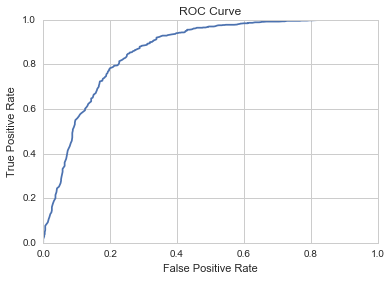

ROC AUC: 0.861


In [8]:
# Evaluate accuracy of model on test set
print "Accuracy of training set: %0.3f" % clf.score(X_train, y_train)
print "Accuracy of test set: %0.3f" % clf.score(X_test, y_test)

# Plot ROC curve and get AUC score
y_pred_proba = clf.predict_proba(X_test)[:,1]

# Determine the false positive and true positive rates
fpr, tpr, t = roc_curve(y_test, y_pred_proba)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Get ROC AUC score
print 'ROC AUC: %0.3f' % roc_auc_score(y_test, y_pred_proba)

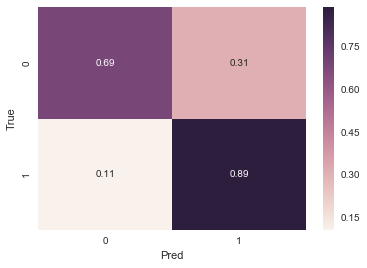

In [9]:
# Get confusion matrix on test set
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, newaxis]

ax = plt.axes()
heatmap(cm_normalized, annot=True)
ax.set_ylabel('True')
ax.set_xlabel('Pred')
plt.show()

In [10]:
df_test = X_test
df_test['predict'] = y_pred
df_test[target] = y_test

/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/sabbir/anaconda2/envs/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
df_test.tail(10)

,year,decade,unique_words,density,unique_words_raw,density_raw,nouns,verbs,adjectives,syllables,most_used_freq,explicit,total_curses,sentiment,sentiment_polarity,predict,charted
3200,2005,2000,85,201,125,443,126,84,18,147,15,0,0,0.9898,1,0,1
3463,2007,2000,31,40,61,170,20,49,3,63,3,0,0,0.8442,1,0,0
1144,1984,1980,41,149,71,339,57,93,11,71,36,0,0,0.9517,1,1,1
2497,1999,1990,72,134,111,285,59,54,16,123,13,0,0,-0.8635,-1,0,1
1398,1987,1980,46,114,81,334,33,90,20,84,18,0,0,0.9938,1,1,1
450,1972,1970,38,93,65,213,37,60,20,76,5,0,0,-0.9509,-1,1,0
3163,2005,2000,55,108,89,269,45,75,14,97,11,0,0,0.9661,1,0,1
2169,1996,1990,38,55,68,157,32,23,8,68,9,0,0,0.2263,1,0,0
166,1965,1960,54,185,94,395,97,58,22,102,9,0,0,0.9933,1,1,1
1532,1989,1980,51,118,85,256,50,72,18,98,10,0,0,0.9349,1,1,1


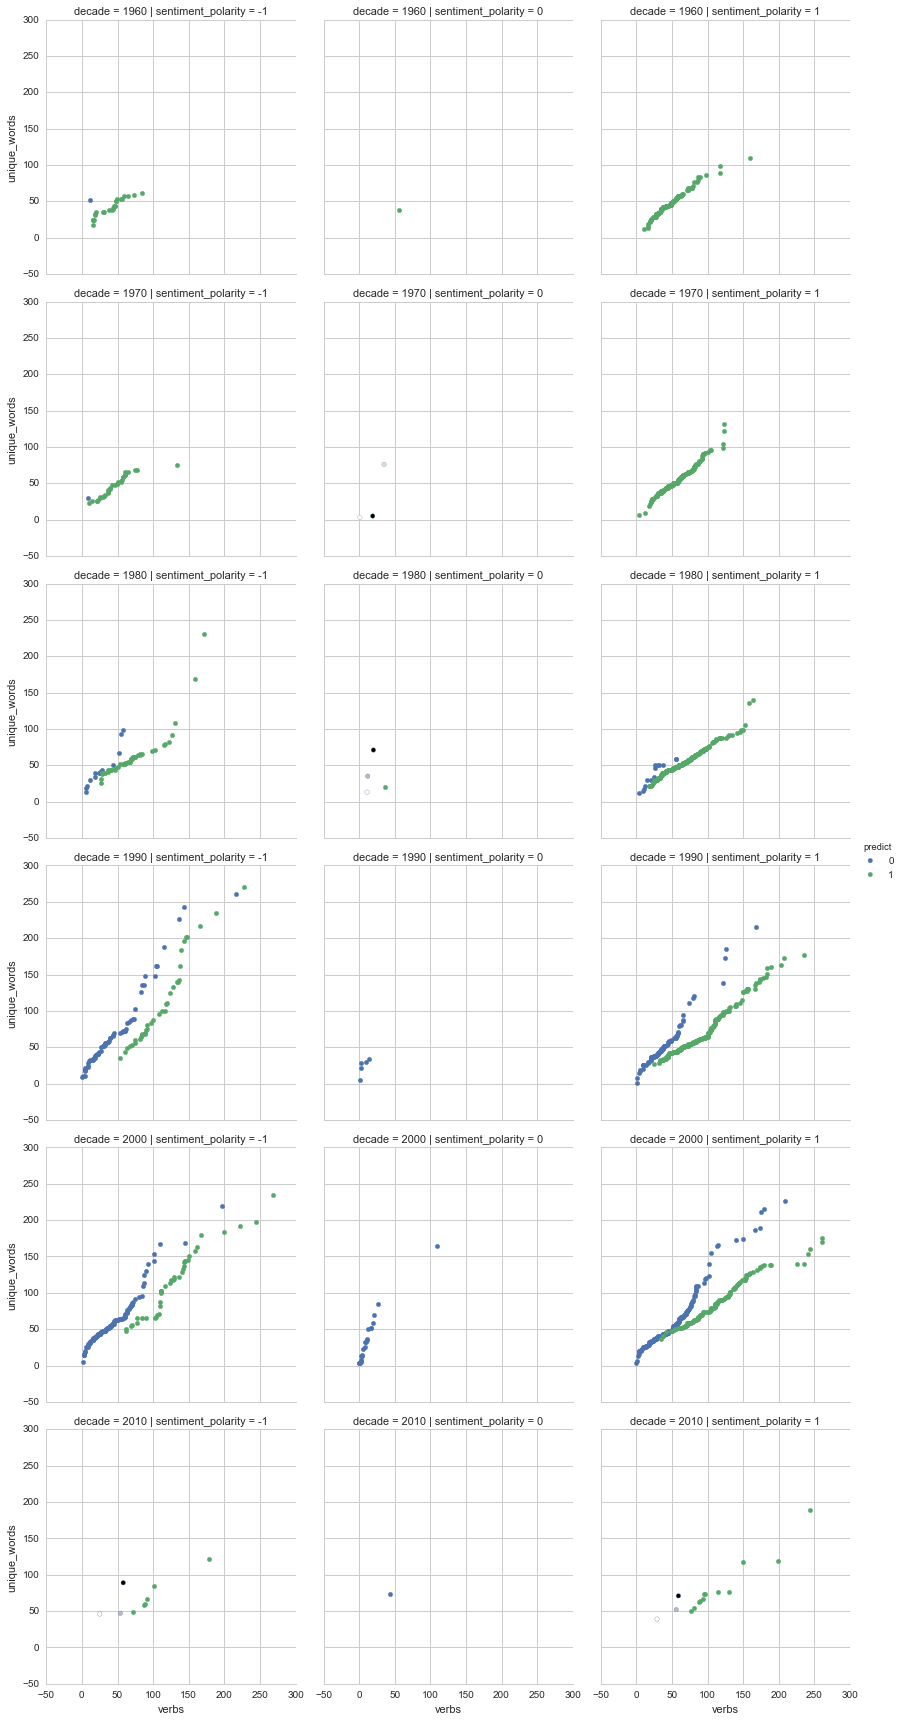

In [29]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

plt.figure(figsize=(12, 5))
g = FacetGrid(df_test, col='sentiment_polarity', hue='predict', row='decade', size=4)
g.map(qqplot, 'verbs', 'unique_words')
g.add_legend()